In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
import time
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("advanced-dls-spring-2021/train.csv")
test = pd.read_csv("advanced-dls-spring-2021/test.csv")

In [3]:
print(data.head(5))
print(data.info())
print(data.shape)

   ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
0            55            19.50    1026.35    Male                0   
1            72            25.85     1872.2    Male                0   
2             1            75.90       75.9    Male                0   
3            32            79.30       2570  Female                1   
4            60           115.25    6758.45  Female                0   

  HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
0        Yes      Yes             Yes                      No   
1        Yes       No             Yes                     Yes   
2         No       No             Yes                      No   
3        Yes       No             Yes                     Yes   
4        Yes      Yes             Yes                     Yes   

  HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
0                 No      No internet service  No internet service   
1                 No      No interne

In [4]:
numerical_fs = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
categorial_fs = [
    'Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
    'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService',
    'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess',
    'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone',
    'IsBillingPaperless', 'PaymentMethod'
]
feature_columns = numerical_fs + categorial_fs
target = 'Churn'

In [5]:
print(data[data.duplicated(keep=False)])

      ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
7                1            45.70       45.7    Male                0   
170              1            69.90       69.9    Male                0   
329              1            69.35      69.35    Male                0   
409              1            69.60       69.6  Female                1   
594              1            20.05      20.05    Male                0   
838              1            19.65      19.65  Female                0   
1068             1            70.15      70.15  Female                0   
1217             1            20.20       20.2    Male                0   
1236             1            45.30       45.3    Male                0   
1384             1            69.90       69.9    Male                0   
1474             1            20.05      20.05    Male                0   
1636             1            19.65      19.65  Female                0   
1898             1       

In [6]:
print(data.isna().sum())
print(data.Churn.value_counts())
plt.pie(data.Churn.value_counts(), autopct='%1.1f%%')
plt.title("Churn Distribution")
# plt.show()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64
Churn
0    3898
1    1384
Name: count, dtype: int64


Text(0.5, 1.0, 'Churn Distribution')

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, j in enumerate(categorial_fs):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    sns.countplot(x=j, hue='Churn', data=data, ax=ax)    
    ax.set_xlabel(j)
    ax.set_ylabel('Количество клиентов')
    ax.set_title(f'Распределение по {j}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
# plt.show()

/var/folders/d5/0bhhtf7147nfb4zc40xcpcq00000gn/T/ipykernel_81120/2828912596.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/d5/0bhhtf7147nfb4zc40xcpcq00000gn/T/ipykernel_81120/2828912596.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/d5/0bhhtf7147nfb4zc40xcpcq00000gn/T/ipykernel_81120/2828912596.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/d5/0bhhtf7147nfb4zc40xcpcq00000gn/T/ipykernel_81120/2828912596.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

In [8]:
print(data.dtypes)

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object


In [9]:
print('''
У уходящих нет DeviceProtection, OnlineBackup, детей, партнера
интернет оптоволокно у них, OnlineSecurityService
''')


У уходящих нет DeviceProtection, OnlineBackup, детей, партнера
интернет оптоволокно у них, OnlineSecurityService



In [10]:
new_data = data.copy()
binary_cols = [col for col in new_data.columns if set(new_data[col].dropna().unique()) <= {'Yes', 'No'}]
new_data[binary_cols] = new_data[binary_cols].replace({'Yes': 1, 'No': 0})
cat_cols = [col for col in new_data.select_dtypes(include=['object']).columns if new_data[col].nunique() <= 10]
new_data = pd.get_dummies(new_data, columns=cat_cols, drop_first=True)
new_data = new_data.apply(pd.to_numeric, errors='coerce')
new_data = new_data.dropna(axis=1, how='all')
ohe_cols = [col for col in new_data.columns if any(c in col for c in cat_cols)]
num_cols = list(set(new_data.columns) - set(ohe_cols))

/var/folders/d5/0bhhtf7147nfb4zc40xcpcq00000gn/T/ipykernel_81120/2032483497.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data[binary_cols] = new_data[binary_cols].replace({'Yes': 1, 'No': 0})


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5]),
 [Text(0.5, 0, 'Sex_Male'),
  Text(1.5, 0, 'HasMultiplePhoneNumbers_No phone service'),
  Text(2.5, 0, 'HasMultiplePhoneNumbers_Yes'),
  Text(3.5, 0, 'HasInternetService_Fiber optic'),
  Text(4.5, 0, 'HasInternetService_No'),
  Text(5.5, 0, 'HasOnlineSecurityService_No internet service'),
  Text(6.5, 0, 'HasOnlineSecurityService_Yes'),
  Text(7.5, 0, 'HasOnlineBackup_No internet service'),
  Text(8.5, 0, 'HasOnlineBackup_Yes'),
  Text(9.5, 0, 'HasDeviceProtection_No internet service'),
  Text(10.5, 0, 'HasDeviceProtection_Yes'),
  Text(11.5, 0, 'HasTechSupportAccess_No internet service'),
  Text(12.5, 0, 'HasTechSupportAccess_Yes'),
  Text(13.5, 0, 'HasOnlineTV_No internet service'),
  Text(14.5, 0, 'HasOnlineTV_Yes'),
  Text(15.5, 0, 'HasMovieSubscription_No internet service'),
  Text(16.5, 0, 'HasMovieSubscription_Yes'),
 

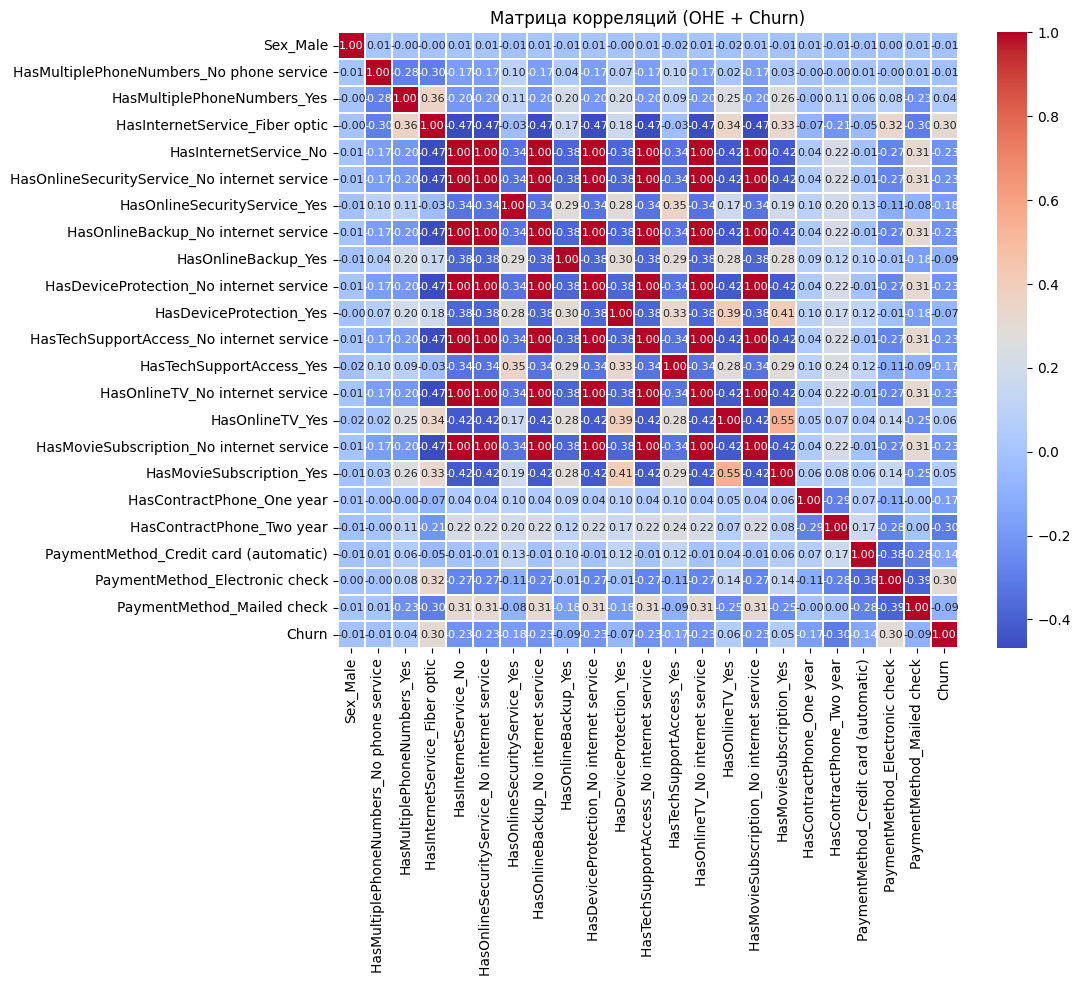

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(new_data[ohe_cols + ['Churn']].corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8}, linewidths=0.2)
plt.title("Матрица корреляций (OHE + Churn)")
plt.xticks(rotation=90)
# plt.show()

(array([0.5]), [Text(0.5, 0, 'Churn')])

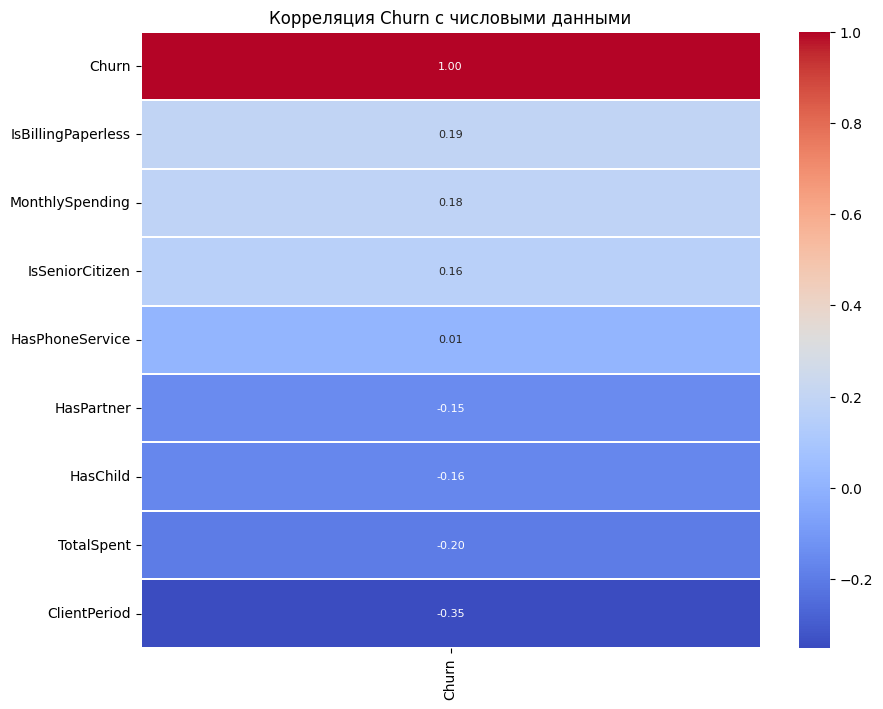

In [12]:
plt.figure(figsize=(10, 8))
corr_matrix = new_data[num_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_with_churn = corr_matrix['Churn']
sns.heatmap(corr_with_churn.to_frame().sort_values(by='Churn', ascending=False), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8}, linewidths=0.2)
plt.title("Корреляция Churn с числовыми данными")
plt.xticks(rotation=90)
# plt.show()

In [13]:
# мусорные колонки
data_clean = data.drop(['HasInternetService', 'HasOnlineTV', 'HasMovieSubscription'], axis=1)

for col in numerical_fs:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    if data[col].isna().sum() > 0:
        print(f"Found {data[col].isna().sum()} NaN values in {col}")
        data[col] = data[col].fillna(data[col].median())

Found 9 NaN values in TotalSpent


In [14]:
# 0/1 и onehot
binary_cols = [col for col in categorial_fs if set(data[col].dropna().unique()) <= {'Yes', 'No'}]
data[binary_cols] = data[binary_cols].replace({'Yes': 1, 'No': 0})
non_binary_cat_cols = [col for col in categorial_fs if col not in binary_cols]
data_encoded = pd.get_dummies(data, columns=non_binary_cat_cols, drop_first=True)

/var/folders/d5/0bhhtf7147nfb4zc40xcpcq00000gn/T/ipykernel_81120/4021420125.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[binary_cols] = data[binary_cols].replace({'Yes': 1, 'No': 0})


In [15]:
features_train = data_encoded.drop(target, axis=1)
target_train = data_encoded[target]

# убрать дырки надо
if features_train.isna().sum().sum() > 0:
    print("Remaining NaNs in features:", features_train.isna().sum())
    features_train = features_train.dropna()
    target_train = target_train.loc[features_train.index]

X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.2, random_state=42)

In [16]:
# скейлим числовые
scaler = StandardScaler()
X_train[numerical_fs] = scaler.fit_transform(X_train[numerical_fs])
X_test[numerical_fs] = scaler.transform(X_test[numerical_fs])

In [17]:
# логрег
start_time = time.time()
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_time = time.time() - start_time
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]
roc_auc_logreg = roc_auc_score(y_test, y_prob_logreg)
print(f"Логистическая регрессия - Время выполнения: {logreg_time:.4f} секунд")
print(f"Логистическая регрессия - ROC AUC: {roc_auc_logreg:.4f}")
print(classification_report(y_test, y_pred_logreg))

Логистическая регрессия - Время выполнения: 0.3328 секунд
Логистическая регрессия - ROC AUC: 0.8288
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       779
           1       0.61      0.47      0.54       278

    accuracy                           0.78      1057
   macro avg       0.72      0.68      0.70      1057
weighted avg       0.77      0.78      0.77      1057



In [18]:
# перцептрончег
start_time = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)
mlp.fit(X_train, y_train)
mlp_time = time.time() - start_time
y_pred_mlp = mlp.predict(X_test)
y_prob_mlp = mlp.predict_proba(X_test)[:, 1]
roc_auc_mlp = roc_auc_score(y_test, y_prob_mlp)
print(f"\nMLP - Время выполнения: {mlp_time:.4f} секунд")
print(f"MLP - ROC AUC: {roc_auc_mlp:.4f}")
print(classification_report(y_test, y_pred_mlp))


MLP - Время выполнения: 31.4512 секунд
MLP - ROC AUC: 0.7558
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       779
           1       0.51      0.39      0.44       278

    accuracy                           0.74      1057
   macro avg       0.65      0.63      0.64      1057
weighted avg       0.72      0.74      0.73      1057



In [19]:
# catboost
data_catboost = data.copy()
for col in numerical_fs:
    data_catboost[col] = pd.to_numeric(data_catboost[col], errors='coerce')
    data_catboost[col] = data_catboost[col].fillna(data_catboost[col].median())
cat_features = [data_catboost.columns.get_loc(col) for col in categorial_fs]
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(
    data_catboost.drop(target, axis=1), data_catboost[target], test_size=0.2, random_state=42
)
start_time = time.time()
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, cat_features=cat_features)
catboost.fit(X_train_cb, y_train_cb)
catboost_time = time.time() - start_time
y_pred_catboost = catboost.predict(X_test_cb)
y_prob_catboost = catboost.predict_proba(X_test_cb)[:, 1]
roc_auc_catboost = roc_auc_score(y_test_cb, y_prob_catboost)
print(f"\nCatBoost - Время выполнения: {catboost_time:.4f} секунд")
print(f"CatBoost - ROC AUC: {roc_auc_catboost:.4f}")
print(classification_report(y_test_cb, y_pred_catboost))


CatBoost - Время выполнения: 5.3404 секунд
CatBoost - ROC AUC: 0.8037
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       779
           1       0.56      0.38      0.46       278

    accuracy                           0.76      1057
   macro avg       0.68      0.64      0.65      1057
weighted avg       0.74      0.76      0.74      1057



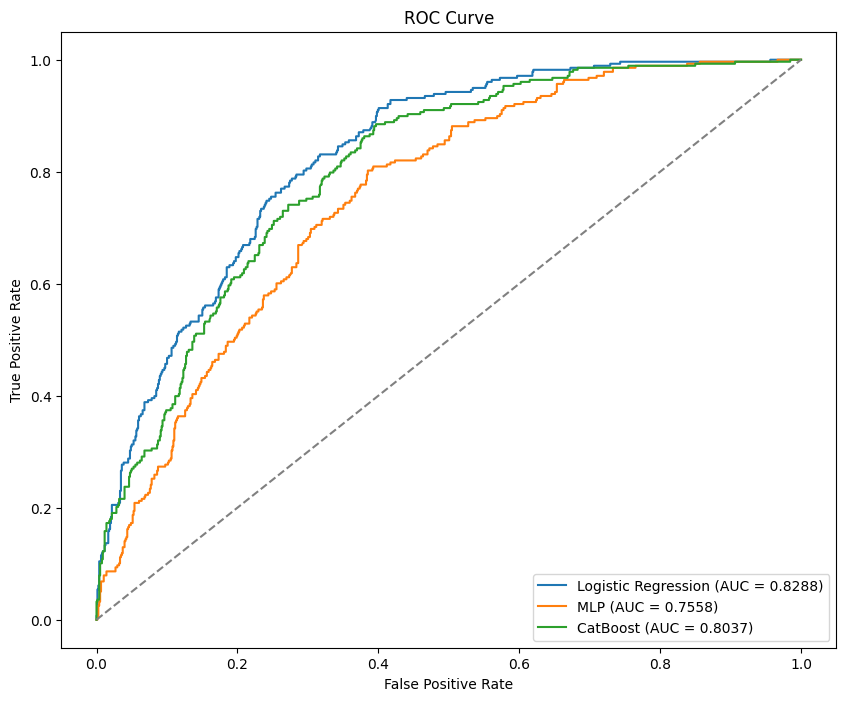

In [20]:
# ROC графики допилить
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
fpr_catboost, tpr_catboost, _ = roc_curve(y_test_cb, y_prob_catboost)
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.4f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_mlp:.4f})')
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost (AUC = {roc_auc_catboost:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
# csv сделать надо
test_data = test.copy()
for col in numerical_fs:
    test_data[col] = pd.to_numeric(test_data[col], errors='coerce')
    test_data[col] = test_data[col].fillna(test_data[col].median())

test_data[binary_cols] = test_data[binary_cols].replace({'Yes': 1, 'No': 0})
test_encoded = pd.get_dummies(test_data, columns=non_binary_cat_cols, drop_first=True)
missing_cols = set(features_train.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0
test_encoded = test_encoded[features_train.columns]
test_encoded[numerical_fs] = scaler.transform(test_encoded[numerical_fs])

logreg_probs = logreg.predict_proba(test_encoded)[:, 1]
submission_logreg = pd.DataFrame({'Id': test.index, 'Churn': logreg_probs})
submission_logreg.to_csv('submission_logreg.csv', index=False)

mlp_probs = mlp.predict_proba(test_encoded)[:, 1]
submission_mlp = pd.DataFrame({'Id': test.index, 'Churn': mlp_probs})
submission_mlp.to_csv('submission_mlp.csv', index=False)

test_catboost = test.copy()
for col in numerical_fs:
    test_catboost[col] = pd.to_numeric(test_catboost[col], errors='coerce')
    test_catboost[col] = test_catboost[col].fillna(test_catboost[col].median())
catboost_probs = catboost.predict_proba(test_catboost)[:, 1]
submission_catboost = pd.DataFrame({'Id': test.index, 'Churn': catboost_probs})
submission_catboost.to_csv('submission_catboost.csv', index=False)

/var/folders/d5/0bhhtf7147nfb4zc40xcpcq00000gn/T/ipykernel_81120/2263151011.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[binary_cols] = test_data[binary_cols].replace({'Yes': 1, 'No': 0})


In [22]:
print(submission_logreg.head())
print(submission_mlp.head())
print(submission_catboost.head())

   Id     Churn
0   0  0.043232
1   1  0.725752
2   2  0.699898
3   3  0.006040
4   4  0.001414
   Id         Churn
0   0  7.617240e-04
1   1  9.883105e-01
2   2  3.852208e-01
3   3  3.423222e-05
4   4  5.271755e-07
   Id     Churn
0   0  0.011959
1   1  0.864021
2   2  0.615335
3   3  0.063855
4   4  0.000294
